In [9]:
import preprocessor

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline

In [11]:
FIGURE_SIZE = (12, 6)

In [12]:
import os

TEST_IMG_OUTPUT_PATH = "test_images_output"

if not os.path.isdir(TEST_IMG_OUTPUT_PATH):
    os.mkdir(TEST_IMG_OUTPUT_PATH)
test_images = [ 'test_images/{}'.format(filename) for filename in os.listdir("test_images/") ]
test_images.sort()
print(test_images)

['test_images/challenge01.jpg', 'test_images/challenge02.jpg', 'test_images/straight_lines1.jpg', 'test_images/straight_lines2.jpg', 'test_images/test1.jpg', 'test_images/test2.jpg', 'test_images/test3.jpg', 'test_images/test4.jpg', 'test_images/test5.jpg', 'test_images/test6.jpg']


In [13]:
from camera_calibrator import CameraCalibrator, Undistorter



In [14]:
calibrator = CameraCalibrator(9, 6)

calibrator.calibrate()

Searching for calibration images at  camera_cal/*.jpg
20 files found for calibration.
Crunching camera_cal/calibration16.jpg ...
Crunching camera_cal/calibration8.jpg ...
Crunching camera_cal/calibration3.jpg ...
Crunching camera_cal/calibration17.jpg ...
Crunching camera_cal/calibration2.jpg ...
Crunching camera_cal/calibration7.jpg ...
Crunching camera_cal/calibration15.jpg ...
Crunching camera_cal/calibration1.jpg ...
Crunching camera_cal/calibration12.jpg ...
Crunching camera_cal/calibration6.jpg ...
Crunching camera_cal/calibration19.jpg ...
Crunching camera_cal/calibration5.jpg ...
Crunching camera_cal/calibration11.jpg ...
Crunching camera_cal/calibration14.jpg ...
Crunching camera_cal/calibration10.jpg ...
Crunching camera_cal/calibration13.jpg ...
Crunching camera_cal/calibration18.jpg ...
Crunching camera_cal/calibration9.jpg ...
Crunching camera_cal/calibration4.jpg ...
Crunching camera_cal/calibration20.jpg ...
Calibration successful


In [15]:
mtx, dist = calibrator.get_calibration_data()
print(mtx, dist, calibrator.get_shape())
undistorter = Undistorter(mtx, dist, calibrator.get_shape())

[[1.15777930e+03 0.00000000e+00 6.67111054e+02]
 [0.00000000e+00 1.15282291e+03 3.86128938e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] [[-0.24688775 -0.02373133 -0.00109842  0.00035108 -0.00258571]] (720, 1280)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


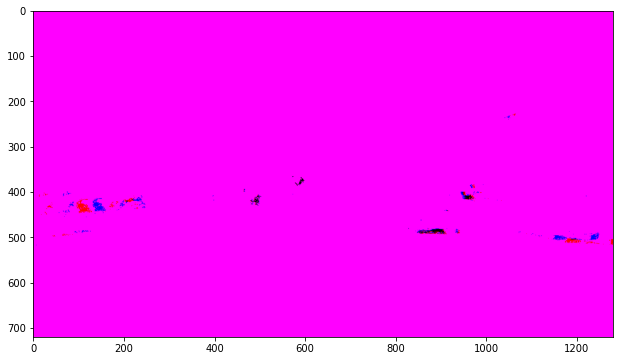

In [16]:
#
#    Calibrator and Undistorter validation
#

img = cv2.imread(test_images[4])
distorted = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
undistorted = undistorter.undistort(distorted)

out_shape = [undistorted.shape[0], undistorted.shape[1], 3]
output = np.zeros(out_shape)
output[:,:,0] = cv2.resize(distorted, (out_shape[1], out_shape[0]))
output[:,:,2] = undistorted
plt.figure(figsize=FIGURE_SIZE)
plt.imshow(output)

In [17]:
def plot_bgr(img):
    """ A helper for plotting a BGR image with matplotlib """
    plt.figure(figsize=FIGURE_SIZE)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
def plot_gray(gray):
    plt.figure(figsize=FIGURE_SIZE)
    plt.imshow(gray, cmap='gray')

def plot_roi_on(img, roi):
    if len(img.shape) == 2:
        output = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    else:
        output = img.copy()
    roi_color = (255, 0, 255)
    thickness = 4
    cv2.polylines(output, [roi], True, roi_color, thickness)
    return output
    
def normalize(img):
    """ Expects a grayscale image """
    minimum = np.min(img)
    maximum = np.max(img)
    normalized = (((img + minimum) / (maximum - minimum) ) * 255).astype(np.uint8)
    return normalized
    
def to_hls_mix(img, save_output=False):
    """ Expects a cv2 mat (in BGR) as input """
    # The idea is to mix Lum and Sat channels to improve lane lines visibility
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    lum = hls[:,:,1].astype(np.int16)
    sat = hls[:,:,2].astype(np.int16)
    mix = (lum * 0.5) + (sat * 0.6 )
    output = normalize(mix)
    if save_output :
        cv2.imwrite(os.path.join(TEST_IMG_OUTPUT_PATH, "stage_01.jpg"), output)
    return output

def to_lumgrad_sat_mix(img, save_output=False):
    """ Expects a cv2 mat (in BGR) as input """
    # The idea is to mix Lum and Sat channels to improve lane lines visibility
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    lum = cv2.medianBlur(hls[:,:,1].astype(np.int16), 3)
    sat = cv2.medianBlur(hls[:,:,2].astype(np.int16), 3)

    #plot_gray(normalize(lum))
    lumgrad = normalize(np.absolute(cv2.Sobel(lum, cv2.CV_64F, 1, 0, ksize=5)))*4
    #lumgrad = normalize(np.absolute(cv2.Laplacian(lum, cv2.CV_64F)))*4
    satgrad = normalize(np.absolute(cv2.Sobel(sat, cv2.CV_64F, 1, 0, ksize=5)))*4
    #satgrad = normalize(np.absolute(cv2.Laplacian(sat, cv2.CV_64F)))*4
    plot_gray(lumgrad)
    plot_gray(satgrad)

    mix = (lumgrad) + (satgrad) + (lum//4) + (sat//4)
    return mix
    

In [18]:
# Good: gray_input, blur_radius=5, sobel_kernel=17 angle_range=(0.7, 1.3), magnitude_range=(75,255)
def amplify_lane_pixels(gray_input, blur_radius=3, sobel_kernel=11
                        , angle_range=(0.7, 1.3), magnitude_range=(30,255), save_output=False):
    """ Finds and amplifies pixels that are looking as lane line markings"""
    # Either medianBlur or GaussianBlur
    # blurred = cv2.medianBlur(gray_input, blur_radius)
    blurred = cv2.GaussianBlur(gray_input, (blur_radius, blur_radius), 0)
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Calculate the direction of the gradient and select only pixels
    # near edges of the matching slope (to the 'angle_range' in radians)
    angles = np.arctan2(abs_sobely, abs_sobelx)
    (angle_min, angle_max) = angle_range
    direction = np.zeros_like(angles)
    direction[(angles >= angle_min) & (angles <= angle_max)] = 1
    # plot_gray(direction)
    # Calculate magnitude of the gradient
    mag_raw = normalize(np.sqrt(np.power(abs_sobelx, 2) + np.power(abs_sobely, 2)))
    min_magnitude, max_magnitude = magnitude_range;
    magnitude = np.zeros_like(blurred)
    magnitude[(mag_raw > min_magnitude) & (mag_raw < max_magnitude)] = 1
    # plot_gray(magnitude)
    # Combining thresholds
    combined = np.zeros_like(blurred)
    combined[((magnitude == 1) & (direction == 1))] = 1
    #combined = magnitude + direction
    # plot_gray(combined)
    dilate_kernel = np.ones((5,5),np.uint8)
    erode_kernel = np.ones((7,7),np.uint8)
    output = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, dilate_kernel)
    #output = cv2.dilate(combined, dilate_kernel)
    #output = cv2.erode(output, erode_kernel)
    #output = cv2.dilate(output, dilate_kernel)
    #output = cv2.erode(output, erode_kernel)
    # output = cv2.erode(combined, kernel)
    # output = cv2.morphologyEx(output, cv2.MORPH_OPEN, dilate_kernel)
    #output = combined
    # plot_gray(output)
    if save_output :
        cv2.imwrite(os.path.join(TEST_IMG_OUTPUT_PATH, "stage_02.jpg"), normalize(output))
    return output

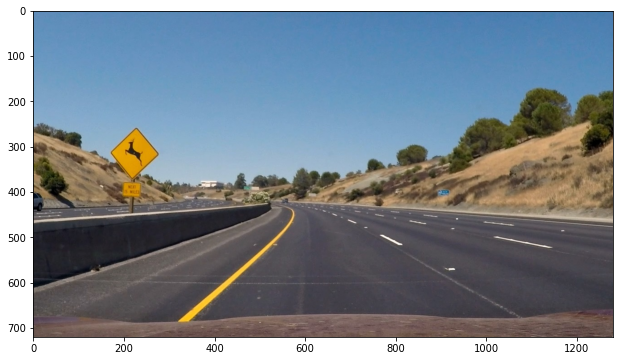

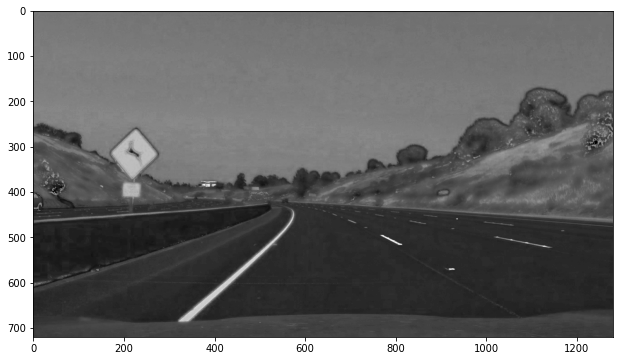

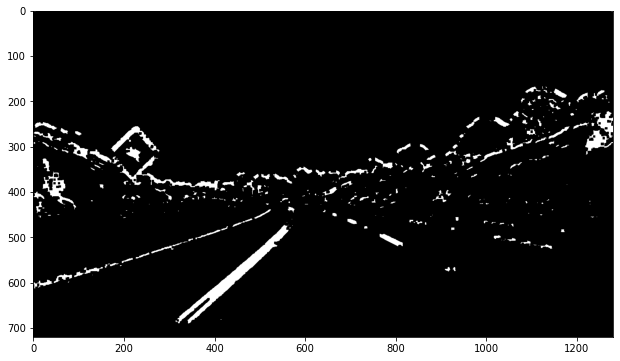

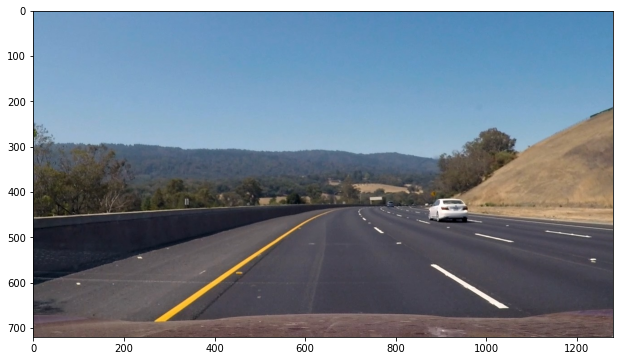

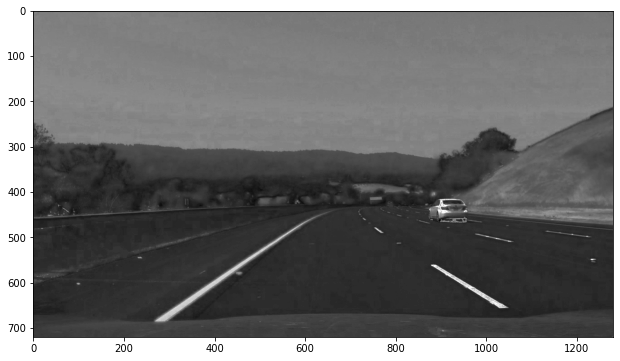

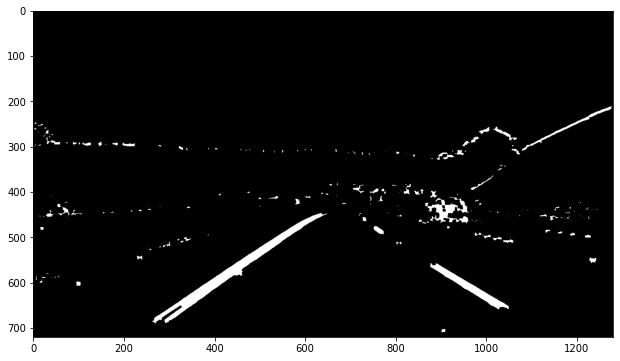

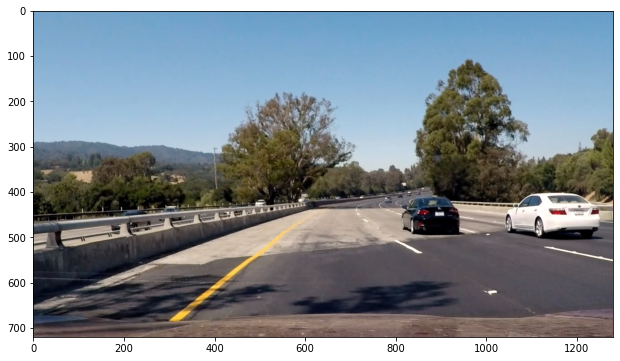

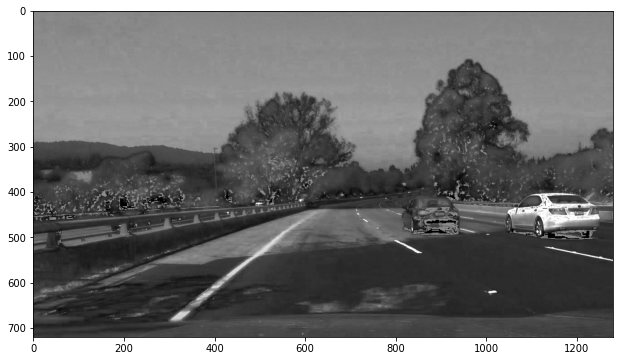

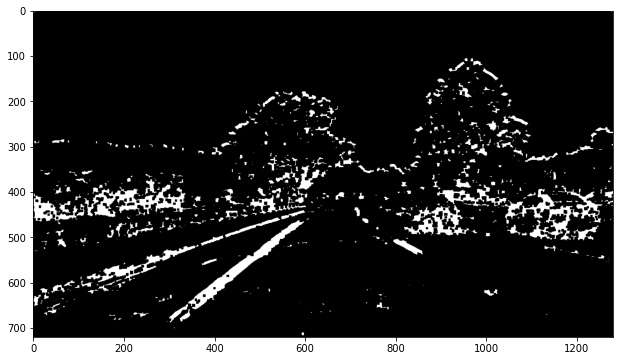

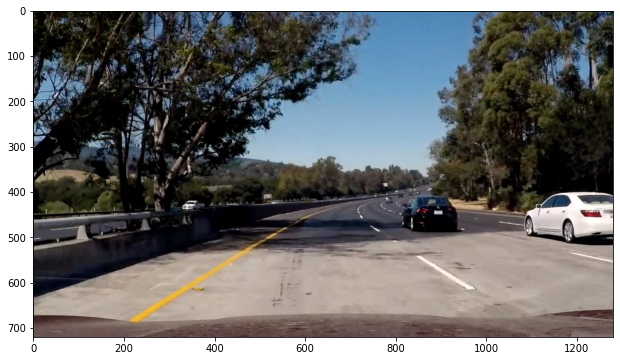

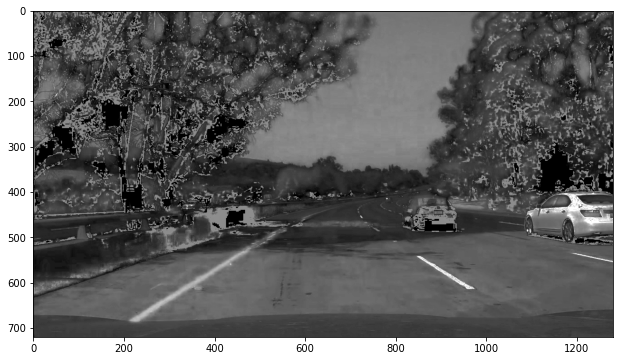

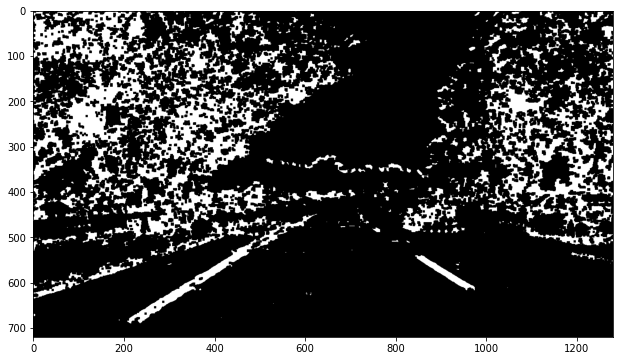

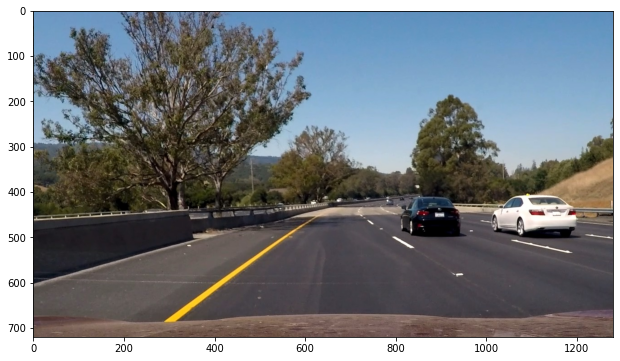

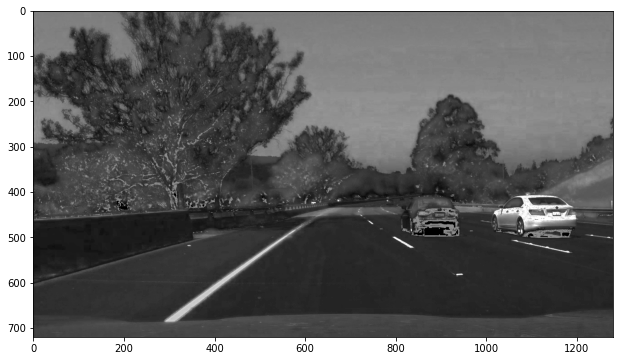

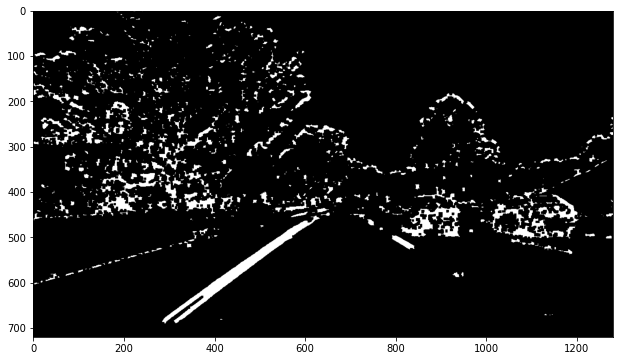

In [19]:
# Validate the pipeline
for test_img in test_images[5:]:
    img = cv2.imread(test_img)
    st_1 = to_hls_mix(img)
    #st_2 = cv2.equalizeHist(st_1)
    st_2 = normalize(amplify_lane_pixels(st_1))
    plot_bgr(img)
    plot_gray(st_1)
    plot_gray(st_2)

    #cv2.imwrite(os.path.join(TEST_IMG_OUTPUT_PATH, "stage_00.jpg"), img)
    
    #hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    #lum = hls[:,:,1].astype(np.int16)
    #sat = hls[:,:,2].astype(np.int16)
    
    #stage_0_sample = to_lumgrad_sat_mix(img, save_output=True) 
    #plot_gray(stage_0_sample)
    
    #st_1_lum = amplify_lane_pixels(lum, blur_radius=9, sobel_kernel=15)
    #st_1_sat = amplify_lane_pixels(sat, blur_radius=9, sobel_kernel=7)
    
    #plot_gray(st_1_lum)
    #plot_gray(st_1_sat)
    #mixed = normalize((st_1_lum) + (st_1_sat*1))
    #plot_gray(normalize(amplify_lane_pixels(mixed)))
    #plot_gray(mixed)
    continue
    
    stage_1_sample = amplify_lane_pixels(stage_0_sample, save_output=True)
    
    #plot_gray(stage_1_sample)
    
    break
    



In [45]:
# TODO: warp transform here.

# TODO: encapsulate the default ROI to a class.
''' OLD roi for a cropped undistortion
h_center = 600
h_offset = 20
top = 370
bottom = 620 #630
left = 100
right = 1100'''
h_center = 640
h_offset = 65
top = 450
bottom = 690
left = 100
right = 1180
CAMERA_ROI = np.array([[left, bottom],
                [h_center - h_offset, top],
                [h_center + h_offset, top],
                [right, bottom]]
               , np.int32)
def to_birdseye(img, roi=CAMERA_ROI):
    """ Expects a trapezoidal ROI to start from the bottom left point """
    """ Expects an undistorted input image """
    birds_top = 100
    birds_bottom = 720
    birds_left = left + 100
    birds_right = right - 100
    birds_roi = np.float32([[birds_left, birds_bottom],
                          [birds_left, birds_top],
                          [birds_right, birds_top],
                          [birds_right, birds_bottom]])
    M = cv2.getPerspectiveTransform(roi.astype(np.float32), birds_roi)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    return warped

    

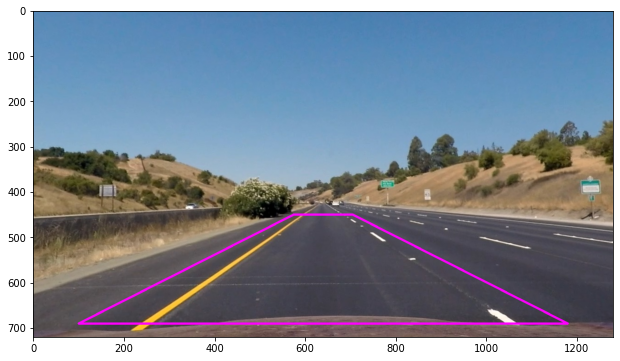

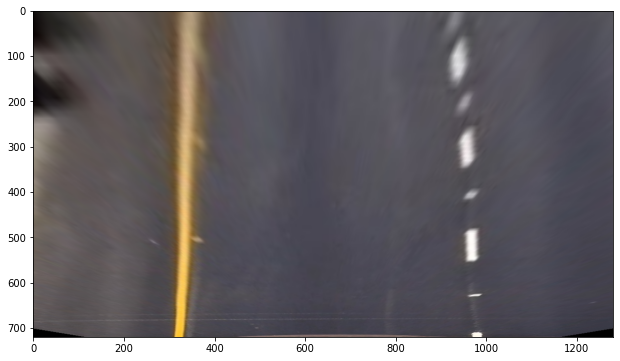

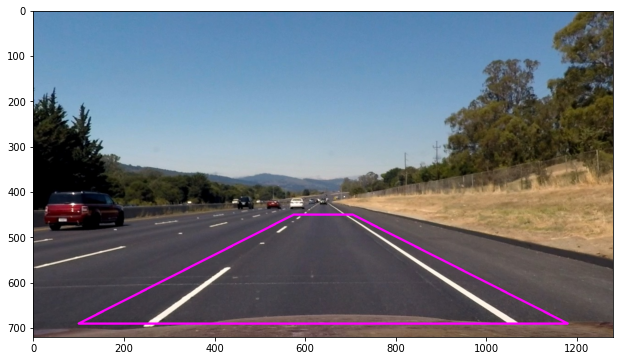

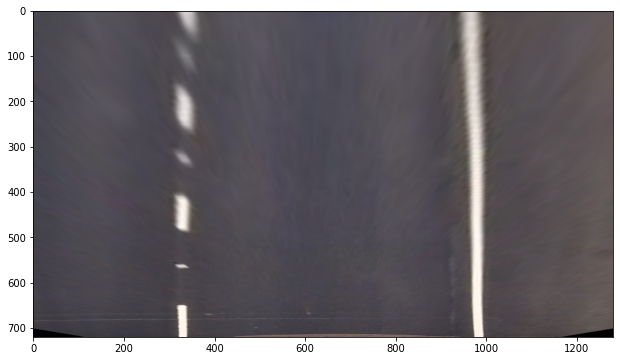

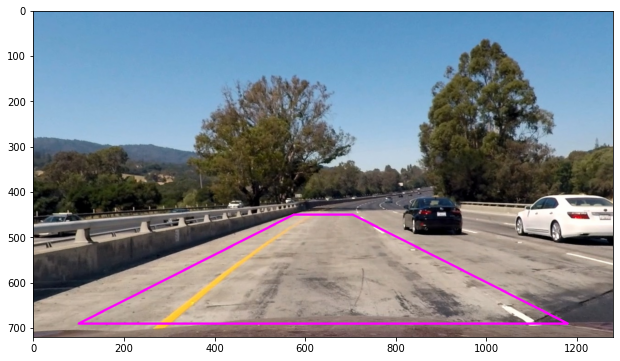

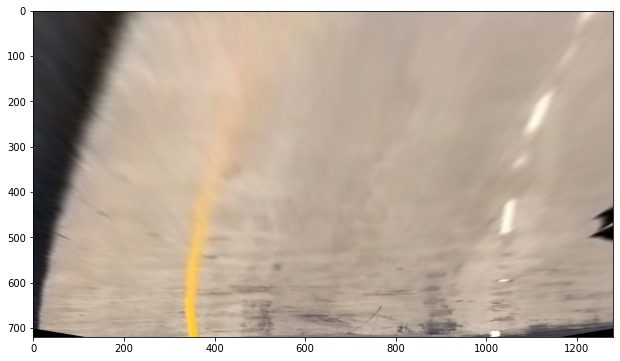

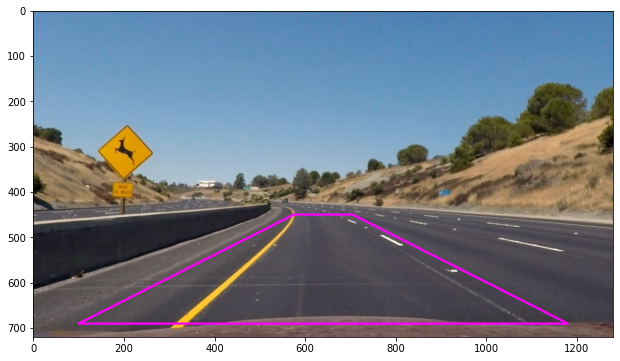

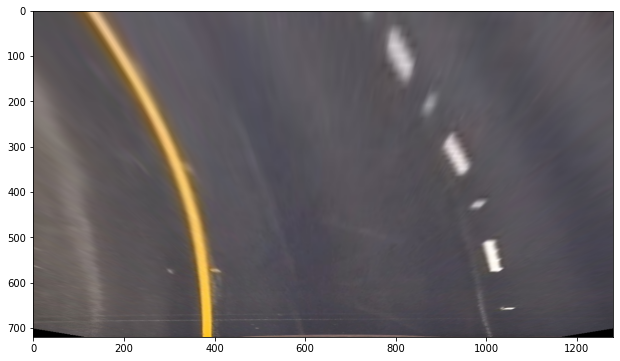

In [46]:
# Validate the warp transform
# https://docs.opencv.org/master/dc/da5/tutorial_py_drawing_functions.html
for test_img in test_images[2:6]:
    img = cv2.imread(test_img)
    
    fpv = undistorter.undistort(img)
    fpv_roi = plot_roi_on(fpv, CAMERA_ROI)
        
    plot_bgr(fpv_roi)
    
    birds_eye = to_birdseye(fpv)

    plot_bgr(birds_eye)
    

In [40]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [41]:
# Note: an Undistorter instance is necessary
def process_frame(frame):
    """ Expects an RGB frame as input """
    height, width, _ = frame.shape
    stage_0_sample = to_hls_mix(frame)
    stage_1_sample = normalize(amplify_lane_pixels(stage_0_sample))
    stage_2_sample = to_birdseye(undistorter.undistort(stage_1_sample))
    tile_00 = cv2.cvtColor(cv2.resize(stage_0_sample, (width//2, height//2)), cv2.COLOR_GRAY2BGR)
    tile_01 = cv2.cvtColor(cv2.resize(stage_1_sample, (width//2, height//2)), cv2.COLOR_GRAY2BGR)
    tile_11 = cv2.cvtColor(cv2.resize(stage_2_sample, (width//2, height//2)), cv2.COLOR_GRAY2BGR)
    output = np.zeros_like(frame)
    output [:height//2, :width//2] = tile_00
    output [:height//2, width//2:] = tile_01
    output [height//2:, :width//2] = cv2.resize(frame, (width//2, height//2))
    output [height//2:, width//2:] = tile_11
    return output
        

In [47]:
test_video_output = 'test_video_output/test_video.mp4'
# input_video = 'harder_challenge_video.mp4'
# input_video = 'challenge_video.mp4'
input_video = 'project_video.mp4'

clip1 = VideoFileClip(input_video).subclip(38,48)
#clip1 = VideoFileClip(input_video)
white_clip = clip1.fl_image(process_frame)
%time white_clip.write_videofile(test_video_output, audio=False)

t:   1%|          | 2/250 [00:00<00:19, 12.82it/s, now=None]

Moviepy - Building video test_video_output/test_video.mp4.
Moviepy - Writing video test_video_output/test_video.mp4



Moviepy - Done !
Moviepy - video ready test_video_output/test_video.mp4
CPU times: user 1min 15s, sys: 5.98 s, total: 1min 21s
Wall time: 41 s
